# 학습 목표 

## 3가지 이상의 모델이 성공적으로 시도

## gensim의 유사단어 찾기를 활용해서 자체 학습한 embedding 과 사전학습 embedding을 비교 분석

## 네이버 감성 영화리뷰 감정정도 분석 정확도 85%이상 달성

### 데이터 임포트 하기

In [11]:
#import trainer
#import data_loader

import tensorflow as tf
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from konlpy.tag import Mecab

### 클래스 정의 하고 베이스 모델 (데이터 로더)

In [12]:
#Base Model (LSTM)
class DataLoader():
    def __init__(self, train_path, test_path):
        self.train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
        self.test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

    def load_data(self, num_words=10000):
        tokenizer = Mecab()
        stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']
        self.train_data.drop_duplicates(subset=['document'], inplace=True)
        self.train_data = self.train_data.dropna(how='any')
        self.test_data.drop_duplicates(subset=['document'], inplace=True)
        self.test_data = self.test_data.dropna(how='any')

        X_train = []
        for sentence in self.train_data['document']:
            temp_X = tokenizer.morphs(sentence)  # 토큰화
            temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
            X_train.append(temp_X)

        X_test = []
        for sentence in self.test_data['document']:
            temp_X = tokenizer.morphs(sentence)  # 토큰화
            temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
            X_test.append(temp_X)

        words = np.concatenate(X_train).tolist()
        counter = Counter(words)
        counter = counter.most_common(num_words - 4)
        vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
        self.word_to_index = {word: index for index, word in enumerate(vocab)}

        def wordlist_to_indexlist(wordlist):
            return [self.word_to_index[word] if word in self.word_to_index else self.word_to_index['<UNK>'] for word in wordlist]

        self.X_train = list(map(wordlist_to_indexlist, X_train))
        self.X_test = list(map(wordlist_to_indexlist, X_test))
        self.Y_train = np.array(list(self.train_data['label']))
        self.Y_test = np.array(list(self.test_data['label']))
        self.tokenizer = tokenizer
        self.counter = counter
        self.vocab = vocab

    def get_maxlen(self):
        total_data_text = list(self.X_train) + list(self.X_test)
        # 텍스트데이터 문장길이의 리스트를 생성한 후
        num_tokens = [len(tokens) for tokens in total_data_text]
        num_tokens = np.array(num_tokens)
        # 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
        print('문장길이 평균 : ', np.mean(num_tokens))
        print('문장길이 최대 : ', np.max(num_tokens))
        print('문장길이 표준편차 : ', np.std(num_tokens))

        # 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
        max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
        self.maxlen = int(max_tokens)
        print('pad_sequences maxlen : ', self.maxlen)
        print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))
        return self.maxlen

    def set_pad(self, padding='post'):
        self.X_train = keras.preprocessing.sequence.pad_sequences(self.X_train,
                                                             value=self.word_to_index["<PAD>"],
                                                             padding='post',  # 혹은 'pre'
                                                             maxlen=self.maxlen)

        self.X_test = keras.preprocessing.sequence.pad_sequences(self.X_test,
                                                            value=self.word_to_index["<PAD>"],
                                                            padding='post',  # 혹은 'pre'
                                                            maxlen=self.maxlen)
        return self.X_train, self.X_test

    def get_data(self, train_idx=30000):
        x_train = self.X_train[:train_idx]
        x_val = self.X_train[train_idx:]

        y_train = self.Y_train[:train_idx]
        y_val = self.Y_train[train_idx:]

        return x_train, y_train, x_val, y_val, self.X_test, self.Y_test

    def get_tokenizer(self):
        return self.tokenizer
    
    def get_counter(self):
        return self.counter

    def get_word_to_index(self):
        return self.word_to_index

    def get_vocab(self):
        return self.vocab

### 테스트/트레인셋 정의 하고 시각화 loss 와 accuracy 함수 구별 및 정의

In [13]:
from sklearn.model_selection import train_test_split

class Trainer():
    def data_split(self, src_data, tgt_data,  val_size = 0.2, test_size = 0.2):
        x_data, self.test_x, y_data, self.test_y = train_test_split(src_data, tgt_data, test_size=test_size)
        self.train_x, self.val_x, self.train_y, self.val_y = train_test_split(x_data, y_data, test_size=val_size)

    def train(self, model, optimizer, loss, epochs=100, batch_size=512, verbose=2):
        model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
        self.hist = model.fit(self.train_x, self.train_y, epochs=epochs, batch_size=batch_size, validation_data=(self.val_x, self.val_y), verbose=verbose)

    def test(self, model):
        test_loss, test_acc = model.evaluate(self.test_x, self.test_y)
        print("test_loss    :{}".format(test_loss))
        print("test_accuracy:{}".format(test_acc))

    def visualization(self):
        history_dict = self.hist.history
        
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
        loss = history_dict['loss']
        val_loss = history_dict['val_loss']

        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(12, 8))

        # loss 그래프
        plt.subplot(1, 2, 1)
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # accuracy 그래프
        plt.subplot(1, 2, 2)
        plt.plot(epochs, acc, 'b', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

### 트레인 테스트 셋 경로 확인

In [14]:
train_path = '~/aiffel/sentiment_classification/data/ratings_train.txt'
test_path = '~/aiffel/sentiment_classification/data/ratings_test.txt'

### 데이터 로더

In [15]:
data_loader = DataLoader(train_path, test_path)

### 문장 길이 확인 하기 (평균, 표준 편차)

In [16]:
num_words = 10000
data_loader.load_data(num_words)
data_loader.get_maxlen()
data_loader.set_pad('post')
x_train, y_train , x_val, y_val, x_test, y_test = data_loader.get_data(train_idx=130000)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 트레인 테스트 검증 셋 확인 

In [17]:
trainer = Trainer()

In [18]:
trainer.train_x = x_train
trainer.val_x = x_val
trainer.test_x = x_test
trainer.train_y = y_train
trainer.val_y = y_val
trainer.test_y = y_test

In [19]:
print(x_train.shape)
print(x_train[0])
print(x_train[0].shape)
#print(keras.layers.Input(shape=(41,)))
#print(keras.layers.Embedding(100, 25)(x_train).shape)

(130000, 41)
[ 32  74 919   4   4  39 228  20  33 748   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
(41,)


In [20]:
x = keras.layers.Embedding(10001, 24)(x_train)
x.shape

TensorShape([130000, 41, 24])

In [21]:
x_train[4]

array([   2, 8894, 1108,   52, 2832,   60,    5,   14, 2758,   41, 1188,
         35,  351,   42,   22,   40,   60,    2,    2,  427, 3102, 1766,
          6,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

### Attention 1 차 에서 3 차 시도 각기 다른 모델들로 구현 

In [22]:
# Attention Model 1st Trials

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 25

lstm_model = keras.Sequential()
lstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim))
lstm_model.add(keras.layers.LSTM(256, activation = 'relu'))
lstm_model.add(keras.layers.Dense(256, activation='relu'))
lstm_model.add(keras.layers.Dense(128, activation='relu'))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 25)          250000    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               288768    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 637,585
Trainable params: 637,585
Non-trainable params: 0
_________________________________________________________________


In [23]:
trainer.train(model=lstm_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
254/254 - 20s - loss: 0.5669 - accuracy: 0.6672 - val_loss: 0.3666 - val_accuracy: 0.8385
Epoch 2/10
254/254 - 18s - loss: 0.3477 - accuracy: 0.8527 - val_loss: 0.3623 - val_accuracy: 0.8449
Epoch 3/10
254/254 - 18s - loss: 0.3191 - accuracy: 0.8665 - val_loss: 0.3410 - val_accuracy: 0.8516
Epoch 4/10
254/254 - 18s - loss: 4.2992 - accuracy: 0.8614 - val_loss: 0.3564 - val_accuracy: 0.8455
Epoch 5/10
254/254 - 18s - loss: 15.5012 - accuracy: 0.6162 - val_loss: 0.6730 - val_accuracy: 0.5695
Epoch 6/10
254/254 - 18s - loss: 0.5467 - accuracy: 0.7947 - val_loss: 0.3944 - val_accuracy: 0.8385
Epoch 7/10
254/254 - 18s - loss: 0.3116 - accuracy: 0.8736 - val_loss: 0.3610 - val_accuracy: 0.8474
Epoch 8/10
254/254 - 18s - loss: 2.3323 - accuracy: 0.7956 - val_loss: 0.5553 - val_accuracy: 0.7198
Epoch 9/10
254/254 - 18s - loss: 0.3580 - accuracy: 0.8499 - val_loss: 0.3690 - val_accuracy: 0.8406
Epoch 10/10
254/254 - 18s - loss: 0.3081 - accuracy: 0.8730 - val_loss: 0.3993 - val_accur

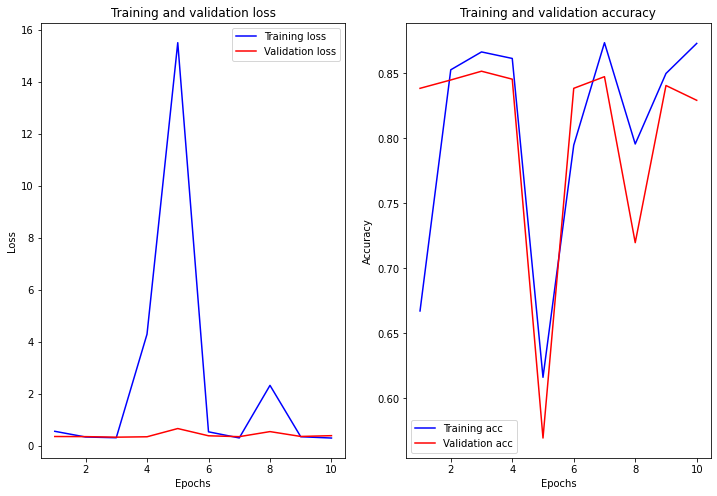

1537/1537 [==============================] - 11s 7ms/step - loss: 0.4018 - accuracy: 0.8296
test_loss    :0.4017896354198456
test_accuracy:0.8295868635177612


In [24]:
trainer.visualization()
trainer.test(lstm_model)

In [25]:
# Attention Model 2nd Trials

input_dim = 41

# input layer
inputs = keras.layers.Input(shape=(input_dim,))

# attention layer
attention_probs = keras.layers.Dense(input_dim, activation='softmax')(inputs)
attention_mul = keras.layers.multiply([inputs, attention_probs])

# fc layer
fc = keras.layers.Dense(64)(attention_mul)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

attention_model = keras.Model(inputs=[inputs], outputs=output)

attention_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 41)           1722        input_1[0][0]                    
__________________________________________________________________________________________________
multiply (Multiply)             (None, 41)           0           input_1[0][0]                    
                                                                 dense_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 64)           2688        multiply[0][0]               

In [26]:
trainer.train(model=attention_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
254/254 - 1s - loss: 2.3382 - accuracy: 0.5002 - val_loss: 1.0878 - val_accuracy: 0.5024
Epoch 2/10
254/254 - 1s - loss: 0.9598 - accuracy: 0.5025 - val_loss: 0.9499 - val_accuracy: 0.5004
Epoch 3/10
254/254 - 1s - loss: 0.9048 - accuracy: 0.5020 - val_loss: 0.9385 - val_accuracy: 0.5037
Epoch 4/10
254/254 - 1s - loss: 0.8911 - accuracy: 0.4988 - val_loss: 0.7844 - val_accuracy: 0.5001
Epoch 5/10
254/254 - 1s - loss: 0.8605 - accuracy: 0.5014 - val_loss: 0.9638 - val_accuracy: 0.4992
Epoch 6/10
254/254 - 1s - loss: 0.8486 - accuracy: 0.4992 - val_loss: 0.8605 - val_accuracy: 0.5015
Epoch 7/10
254/254 - 1s - loss: 0.8450 - accuracy: 0.4997 - val_loss: 0.7927 - val_accuracy: 0.5041
Epoch 8/10
254/254 - 1s - loss: 0.8052 - accuracy: 0.5018 - val_loss: 0.8632 - val_accuracy: 0.5020
Epoch 9/10
254/254 - 1s - loss: 0.7975 - accuracy: 0.5007 - val_loss: 0.7966 - val_accuracy: 0.5011
Epoch 10/10
254/254 - 1s - loss: 0.7920 - accuracy: 0.5009 - val_loss: 0.8503 - val_accuracy: 0.5051

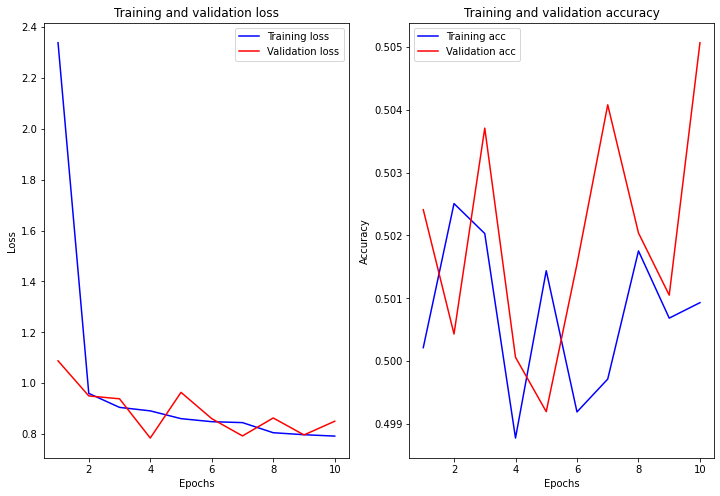

In [27]:
trainer.visualization()

In [28]:
trainer.test(attention_model)

1537/1537 [==============================] - 2s 1ms/step - loss: 0.8735 - accuracy: 0.5056
test_loss    :0.8734568953514099
test_accuracy:0.5056045055389404


In [29]:
# Attention Model 3rd Trials

vocab_size = 10000   
word_vector_dim = 25
input_dim = 41

# input layer
inputs = keras.layers.Input(shape=(input_dim,))

# attention layer
attention_probs = keras.layers.Dense(input_dim, activation='softmax')(inputs)
attention_mul = keras.layers.multiply([inputs, attention_probs])

embed_layer = keras.layers.Embedding(vocab_size, word_vector_dim)(attention_mul)

# lstm layer
lstm_layer = keras.layers.LSTM(256, activation='relu')(embed_layer)

# fc layer
fc = keras.layers.Dense(64)(lstm_layer)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

attention_lstm_model = keras.Model(inputs=[inputs], outputs=output)

attention_lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 41)           1722        input_2[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 41)           0           input_2[0][0]                    
                                                                 dense_6[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 41, 25)       250000      multiply_1[0][0]           

In [30]:
trainer.train(model=attention_lstm_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
254/254 - 19s - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.5036
Epoch 2/10
254/254 - 17s - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6931 - val_accuracy: 0.4994
Epoch 3/10
254/254 - 17s - loss: 0.6919 - accuracy: 0.5104 - val_loss: 0.6904 - val_accuracy: 0.5234
Epoch 4/10
254/254 - 17s - loss: 0.6837 - accuracy: 0.5450 - val_loss: 0.6886 - val_accuracy: 0.5269
Epoch 5/10
254/254 - 17s - loss: 0.6783 - accuracy: 0.5499 - val_loss: 0.6928 - val_accuracy: 0.5281
Epoch 6/10
254/254 - 17s - loss: 0.6757 - accuracy: 0.5533 - val_loss: 0.6921 - val_accuracy: 0.5281
Epoch 7/10
254/254 - 17s - loss: 0.6733 - accuracy: 0.5556 - val_loss: 0.6928 - val_accuracy: 0.5275
Epoch 8/10
254/254 - 17s - loss: 0.6723 - accuracy: 0.5574 - val_loss: 0.6992 - val_accuracy: 0.5289
Epoch 9/10
254/254 - 17s - loss: 0.6706 - accuracy: 0.5561 - val_loss: 0.7102 - val_accuracy: 0.5305
Epoch 10/10
254/254 - 17s - loss: 0.6686 - accuracy: 0.5578 - val_loss: 0.7152 - val_accura

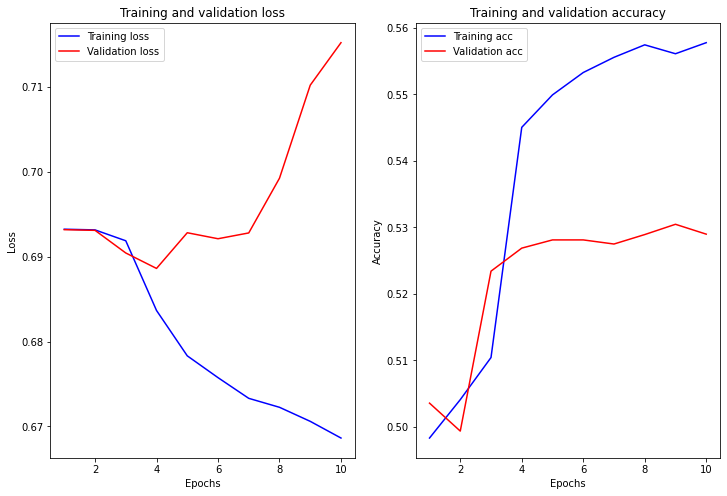

1537/1537 [==============================] - 2s 2ms/step - loss: 0.8735 - accuracy: 0.5056
test_loss    :0.8734568953514099
test_accuracy:0.5056045055389404


In [32]:
trainer.visualization()
trainer.test(attention_model)

In [33]:
#Attention Before LSTM (4th Trials)
vocab_size = 10000   
word_vector_dim = 25
time_steps = 41

# input layer
inputs = keras.layers.Input(shape=(time_steps,))

embed = keras.layers.Embedding(vocab_size, word_vector_dim)(inputs)

# attention layer
# inputs.shape = (batch_size, time_steps, input_dim)

a = keras.layers.Permute((2, 1))(embed) # same transpose
#a = tf.keras.layers.Reshape((input_dim, TIME_STEPS))(a) 
# this line is not useful. It's just to know which dimension is what.
a = keras.layers.Dense(time_steps, activation='softmax')(a)
a_probs = keras.layers.Permute((2, 1), name='attention_vec')(a)
output_attention_mul  = keras.layers.multiply([embed, a_probs])


# lstm layer
lstm_out = keras.layers.LSTM(256, return_sequences=True, activation='relu')(output_attention_mul)

# fc layer
fc = keras.layers.Dense(64)(lstm_out)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

attention_3d_model = keras.Model(inputs=[inputs], outputs=output)

attention_3d_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 41, 25)       250000      input_3[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 25, 41)       0           embedding_3[0][0]                
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 25, 41)       1722        permute[0][0]                    
____________________________________________________________________________________________

In [34]:
trainer.train(model=attention_3d_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)
trainer.test(attention_3d_model)

Epoch 1/10
254/254 - 20s - loss: 0.6927 - accuracy: 0.5069 - val_loss: 0.6675 - val_accuracy: 0.5963
Epoch 2/10
254/254 - 19s - loss: 0.4613 - accuracy: 0.7786 - val_loss: 0.4055 - val_accuracy: 0.8140
Epoch 3/10
254/254 - 18s - loss: 0.3826 - accuracy: 0.8275 - val_loss: 0.3902 - val_accuracy: 0.8223
Epoch 4/10
254/254 - 19s - loss: 0.3613 - accuracy: 0.8404 - val_loss: 0.3798 - val_accuracy: 0.8317
Epoch 5/10
254/254 - 18s - loss: 0.3409 - accuracy: 0.8522 - val_loss: 0.3714 - val_accuracy: 0.8375
Epoch 6/10
254/254 - 18s - loss: 0.3204 - accuracy: 0.8639 - val_loss: 0.3670 - val_accuracy: 0.8383
Epoch 7/10
254/254 - 18s - loss: 0.3018 - accuracy: 0.8742 - val_loss: 0.3688 - val_accuracy: 0.8434
Epoch 8/10
254/254 - 18s - loss: 0.2876 - accuracy: 0.8807 - val_loss: 0.3729 - val_accuracy: 0.8403
Epoch 9/10
254/254 - 18s - loss: 0.2728 - accuracy: 0.8886 - val_loss: 0.3734 - val_accuracy: 0.8406
Epoch 10/10
254/254 - 18s - loss: 0.2576 - accuracy: 0.8970 - val_loss: 0.3803 - val_accura

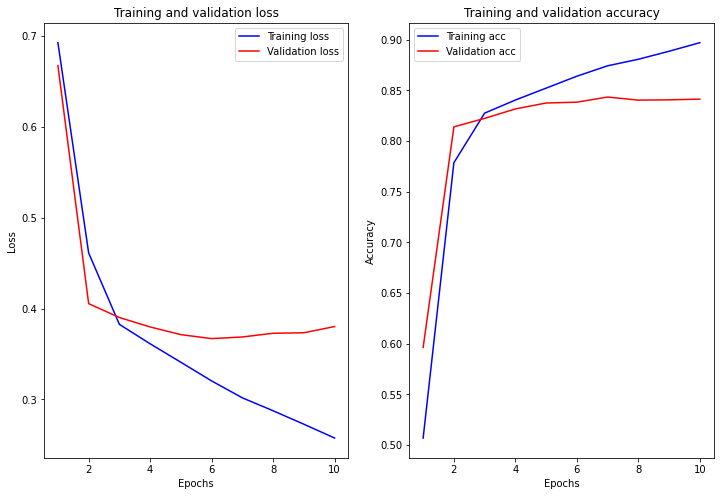

In [35]:
trainer.visualization()

In [38]:
def view_attention_vector(model, test_x, i):
	layer_outputs    = [layer.output for layer in model.layers if layer.name == 'attention_vec']
	activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
	output_data = activation_model.predict(test_x)
	output_data = keras.layers.Permute((2, 1))(output_data)
	print(output_data[i].shape)
	attention_vector = np.mean(output_data[i], axis=0)
	df = pd.DataFrame(attention_vector.transpose(), columns=['attention (%)'])
	df.plot.bar()

(25, 41)


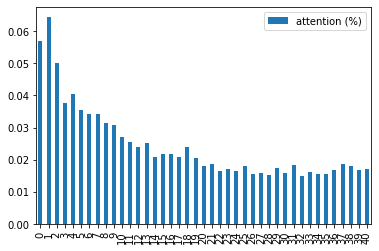

In [39]:
view_attention_vector(attention_3d_model, x_test, 3)

In [40]:
#Attention After LSTM (5th Trials)

vocab_size = 10000   
word_vector_dim = 25
time_steps = 41

# input layer
inputs = keras.layers.Input(shape=(time_steps,))

embed = keras.layers.Embedding(vocab_size, word_vector_dim)(inputs)

# lstm layer
lstm_out = keras.layers.LSTM(256, return_sequences=True, activation='relu')(embed)

# attention layer
a = keras.layers.Permute((2, 1))(lstm_out)
a = keras.layers.Dense(time_steps, activation='softmax')(a)
a_probs = keras.layers.Permute((2, 1), name='attention_vec')(a)
attention_mul = keras.layers.multiply([lstm_out, a_probs])

# fc layer
fc = keras.layers.Dense(64)(attention_mul)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

Att_after_LSTM = keras.Model(inputs=[inputs], outputs=output)

Att_after_LSTM.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 41, 25)       250000      input_4[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 41, 256)      288768      embedding_4[0][0]                
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 256, 41)      0           lstm_3[0][0]                     
____________________________________________________________________________________________

In [41]:
trainer.train(model=Att_after_LSTM, optimizer='adam', loss='binary_crossentropy', epochs=15, verbose=2)
trainer.test(Att_after_LSTM)

Epoch 1/15
254/254 - 19s - loss: 0.5580 - accuracy: 0.6931 - val_loss: 0.4178 - val_accuracy: 0.8031
Epoch 2/15
254/254 - 18s - loss: 0.3837 - accuracy: 0.8261 - val_loss: 0.3805 - val_accuracy: 0.8291
Epoch 3/15
254/254 - 18s - loss: 0.3470 - accuracy: 0.8480 - val_loss: 0.3706 - val_accuracy: 0.8366
Epoch 4/15
254/254 - 18s - loss: 0.3164 - accuracy: 0.8672 - val_loss: 0.3503 - val_accuracy: 0.8485
Epoch 5/15
254/254 - 18s - loss: 0.2934 - accuracy: 0.8784 - val_loss: 0.3461 - val_accuracy: 0.8510
Epoch 6/15
254/254 - 18s - loss: 0.2720 - accuracy: 0.8893 - val_loss: 0.3516 - val_accuracy: 0.8559
Epoch 7/15
254/254 - 19s - loss: 0.2542 - accuracy: 0.8975 - val_loss: 0.3431 - val_accuracy: 0.8555
Epoch 8/15
254/254 - 19s - loss: 0.2376 - accuracy: 0.9056 - val_loss: 0.3838 - val_accuracy: 0.8543
Epoch 9/15
254/254 - 19s - loss: 0.2233 - accuracy: 0.9121 - val_loss: 0.3844 - val_accuracy: 0.8466
Epoch 10/15
254/254 - 18s - loss: 0.2093 - accuracy: 0.9186 - val_loss: 0.3902 - val_accura

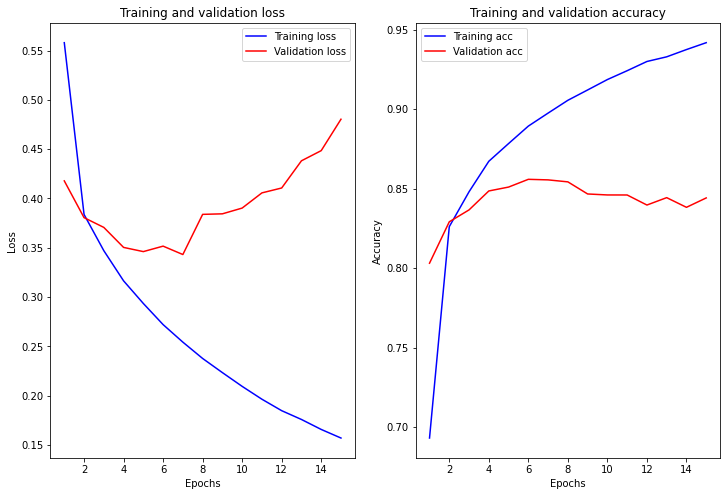

In [42]:
trainer.visualization()

(256, 41)


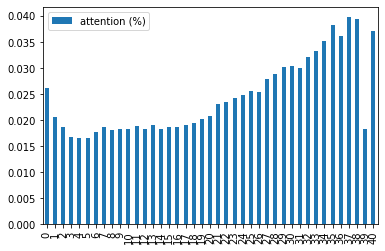

In [43]:
view_attention_vector(Att_after_LSTM, x_test, 3)

In [44]:
#Transformer도 이용해보자

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = keras.layers.Dense(embedding_dim)
        self.key_dense = keras.layers.Dense(embedding_dim)
        self.value_dense = keras.layers.Dense(embedding_dim)
        self.dense = keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [45]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(dff, activation="relu"),
             keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

In [46]:
class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = range(0, max_len, 1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [47]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기
vocab_size = 10000
max_len = 41

inputs = keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(20, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

transformer = keras.Model(inputs=inputs, outputs=outputs)
transformer.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
token_and_position_embedding (None, 41, 32)            321312    
_________________________________________________________________
transformer_block (Transform (None, 41, 32)            6464      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 20)                660       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0   

In [48]:
trainer.train(model=transformer, optimizer='adam', loss='binary_crossentropy', epochs=5, verbose=2)

Epoch 1/5
254/254 - 4s - loss: 0.4352 - accuracy: 0.7929 - val_loss: 0.3779 - val_accuracy: 0.8291
Epoch 2/5
254/254 - 2s - loss: 0.3393 - accuracy: 0.8547 - val_loss: 0.3706 - val_accuracy: 0.8363
Epoch 3/5
254/254 - 2s - loss: 0.3197 - accuracy: 0.8625 - val_loss: 0.3499 - val_accuracy: 0.8456
Epoch 4/5
254/254 - 2s - loss: 0.3041 - accuracy: 0.8685 - val_loss: 0.3507 - val_accuracy: 0.8472
Epoch 5/5
254/254 - 2s - loss: 0.2899 - accuracy: 0.8705 - val_loss: 0.3743 - val_accuracy: 0.8424


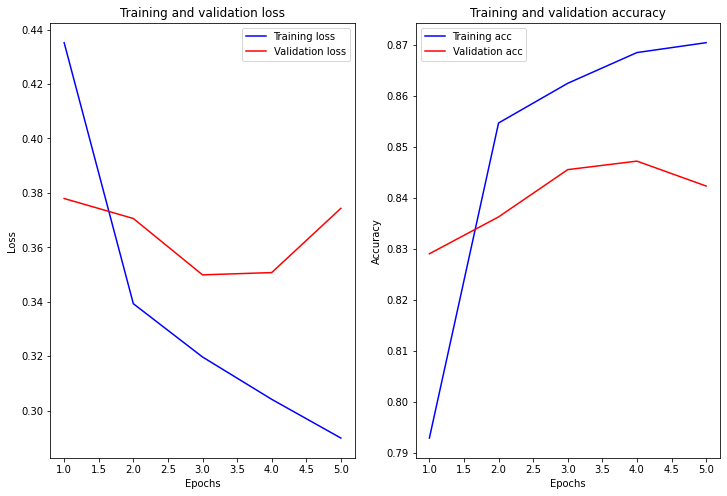

1537/1537 [==============================] - 5s 3ms/step - loss: 0.3788 - accuracy: 0.8416
test_loss    :0.3788076639175415
test_accuracy:0.841609537601471


In [49]:
trainer.visualization()
trainer.test(transformer)

## gensim을 활용하여, 사전에 학습된 임베딩 레이어 분석 및 비교

In [52]:
!pip freeze

absl-py==0.12.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1637087032947/work
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1636093929600/work
albumentations==1.1.0
antlr4-python3-runtime==4.8
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1637703202493/work/dist
appdirs==1.4.4
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1636021379509/work
astunparse==1.6.3
async-generator==1.10
async-timeout @ file:///home/conda/feedstock_root/build_artifacts/async-timeout_1637092647930/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1620387926260/work
audioread==2.1.9
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1618230623929/work
beautifulsoup4==4.6.0
black==21.12b0
bleach @ file:///home/conda/feedstock_root/build_artifacts/ble

In [53]:
!pip install --upgrade gensim==3.8.3

     |████████████████████████████████| 23.4 MB 8.3 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=24328218 sha256=31f673782d43d108fb0b43c3db19ea7e79485eca335c0826cb54a036ac9c6c6f
  Stored in directory: /aiffel/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2


In [71]:
from gensim.models import KeyedVectors

word2vec_model_English = KeyedVectors.load_word2vec_format(
    '/aiffel/aiffel/sentiment_classification/data/word2vec.txt',
    binary=False
)

### vocab 확인

In [72]:
print(len(word2vec_model_English.vocab))

9996


### 한국어로 되어 있는지 확인

In [73]:
print("재밌다" in word2vec_model_English.vocab)
print("코딩" in word2vec_model_English.vocab)

False
False


### 한국어가 아닌걸 확인 하고, 어느 언어로 구성 되어 있는지 확인

In [74]:
print(list(word2vec_model_English.vocab.keys())[:100])  # or word2vec_model.index2word[:100]

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all', 'at', 'by', 'an', 'they', 'who', 'so', 'from', 'like', 'her', 'or', 'just', 'about', "it's", 'out', 'has', 'if', 'some', 'there', 'what', 'good', 'more', 'when', 'very', 'up', 'no', 'time', 'she', 'even', 'my', 'would', 'which', 'only', 'story', 'really', 'see', 'their', 'had', 'can', 'were', 'me', 'well', 'than', 'we', 'much', 'been', 'bad', 'get', 'will', 'do', 'also', 'into', 'people', 'other', 'first', 'great', 'because', 'how', 'him', 'most', "don't", 'made', 'its', 'then', 'way', 'make', 'them', 'too', 'could', 'any', 'movies', 'after']


### 저장해둔 파일 위치 다시 확인

In [80]:
import gensim

word2vec_model = gensim.models.Word2Vec.load('./data/word2vec_ko.model')

FileNotFoundError: [Errno 2] No such file or directory: './data/word2vec_ko.model'

In [81]:
import os
print(os.getcwd())

/workspace/userdisk/AIFFEL_quest_rs/Exploration/Ex05


In [82]:
import os
print(os.path.exists('/aiffel/data/word2vec_ko.model'))

True


### 저장 위치 확인 후, 데이터로드 통해서 불러오고 다시 한국어 인지 확인

In [85]:
import gensim

word2vec_model = gensim.models.Word2Vec.load('/aiffel/data/word2vec_ko.model')

In [90]:
vocab = data_loader.get_vocab()
print(len(vocab))
vocab

10000


['<PAD>',
 '<BOS>',
 '<UNK>',
 '<UNUSED>',
 '.',
 '영화',
 '다',
 '고',
 '하',
 '을',
 '보',
 '..',
 '게',
 ',',
 '!',
 '지',
 '있',
 '없',
 '?',
 '좋',
 '나',
 '었',
 '만',
 '는데',
 '너무',
 '봤',
 '적',
 '안',
 '정말',
 '로',
 '음',
 '것',
 '아',
 '네요',
 '재밌',
 '어',
 '같',
 '점',
 '지만',
 '진짜',
 '했',
 '에서',
 '기',
 '네',
 '않',
 '거',
 '았',
 '수',
 '되',
 '면',
 'ㅋㅋ',
 '말',
 '연기',
 '인',
 '주',
 '내',
 '최고',
 '~',
 '평점',
 '이런',
 '던',
 '어요',
 '할',
 '왜',
 '겠',
 '1',
 '스토리',
 '해',
 '습니다',
 'ㅋㅋㅋ',
 '...',
 '드라마',
 '생각',
 '아니',
 '더',
 '그',
 '싶',
 '사람',
 '듯',
 '때',
 '감동',
 '함',
 '배우',
 '본',
 '까지',
 '뭐',
 '알',
 '만들',
 '내용',
 '볼',
 '감독',
 '보다',
 '라',
 '그냥',
 '재미',
 '시간',
 '지루',
 '중',
 '재미있',
 '년',
 '10',
 '였',
 '잼',
 '사랑',
 '못',
 '냐',
 '재미없',
 '쓰레기',
 '서',
 '2',
 '라고',
 '야',
 '니',
 '면서',
 '번',
 '다시',
 '나오',
 '작품',
 '이거',
 '하나',
 '줄',
 '해서',
 '개',
 '남',
 '정도',
 '마지막',
 '끝',
 '이건',
 '액션',
 '임',
 'ㅋ',
 '3',
 '기대',
 '입니다',
 '건',
 '라는',
 '분',
 '완전',
 '다는',
 '참',
 '많',
 '처음',
 '장면',
 '대',
 '아깝',
 '다가',
 '으면',
 '지금',
 '모르',
 '이렇게',
 "'",

### 비슷한 단어 찾기

In [91]:
word2vec_model.wv.most_similar("스토리")

[('줄거리', 0.7535022497177124),
 ('캐릭터', 0.725022554397583),
 ('시나리오', 0.7141813039779663),
 ('어드벤처', 0.6698622703552246),
 ('아바타', 0.6645265817642212),
 ('퀘스트', 0.6644596457481384),
 ('엔딩', 0.6584070920944214),
 ('코믹', 0.6568388938903809),
 ('유머', 0.6488963961601257),
 ('비하인드', 0.6481383442878723)]

In [92]:
word2vec_model["스토리"]

/tmp/ipykernel_468/1726716326.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  word2vec_model["스토리"]


array([-1.2868382 , -2.507531  , -0.9214199 ,  3.0587573 , -1.0719198 ,
       -0.5368897 , -2.012266  , -3.5554576 , -3.231739  ,  0.16307035,
       -0.59722006, -0.72075456, -0.4279868 , -0.19383056,  2.3871145 ,
        4.965005  ,  0.26044092,  0.9522533 ,  0.83466417,  0.9172365 ,
        1.2815846 ,  0.08996281, -1.0427315 , -2.3430946 , -2.5059114 ,
        0.030618  , -0.5639845 ,  4.147861  , -0.61100155, -0.8690846 ,
       -1.5095218 ,  0.91739756,  1.1262051 , -1.30922   ,  0.923657  ,
        2.086937  , -0.8366984 ,  1.2309449 , -4.462606  ,  0.48946074,
        2.634355  , -2.4475555 ,  2.4415903 ,  4.3363576 , -1.1428844 ,
        3.0889473 ,  1.8819897 ,  1.4218955 ,  1.760429  , -0.3748059 ,
        0.6312986 ,  0.19656628,  1.6872926 , -1.4868659 ,  1.0378553 ,
       -1.9060152 ,  2.2589114 , -2.2143507 ,  2.4099011 ,  0.01268054,
        1.7657253 ,  0.6589781 , -1.3827784 , -2.1160715 , -0.90059763,
       -1.2719239 , -1.1218114 ,  2.5833495 , -0.27548176, -1.19

### word embedding 확인

In [108]:
vocab_size = num_words

embedding_matrix=np.zeros((vocab_size, 200))
print(np.shape(embedding_matrix))

(10000, 200)


In [109]:
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [110]:
get_vector(vocab[5])

/tmp/ipykernel_468/3612596859.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in word2vec_model:
/tmp/ipykernel_468/3612596859.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return word2vec_model[word]


array([-1.8007389 , -1.1790098 , -2.4066596 ,  2.1384156 , -0.3537603 ,
        1.3749527 , -4.894612  , -3.6517198 ,  0.4411444 ,  0.78153926,
       -2.696888  , -1.7812852 , -2.1514654 , -4.813236  ,  2.7465918 ,
       -2.1620324 , -0.11467794, -1.2431171 ,  2.3979309 , -1.1060628 ,
       -0.41043055,  1.9500391 ,  0.7821002 ,  1.5899978 ,  1.6447444 ,
       -2.1265035 , -1.7981595 ,  1.7535795 ,  0.53717697, -1.212121  ,
       -4.466316  ,  4.5488324 ,  1.334441  , -0.9070271 ,  1.1931889 ,
        4.1563215 ,  1.9758307 , -0.9437562 , -0.2592725 ,  0.34935686,
        1.8562875 , -3.3249645 ,  1.1221625 ,  1.2836524 ,  3.9211376 ,
        3.8023994 ,  2.766269  ,  0.67293745,  2.2853644 , -5.1131716 ,
        0.32525915, -3.3079958 ,  5.3043513 , -3.8813758 , -0.32960036,
       -1.9527504 ,  3.8865075 , -3.5470378 , -0.21991685,  0.82119733,
       -0.9492492 ,  3.5472107 ,  1.322048  , -0.70640826,  0.52253807,
        1.4683235 , -1.1018689 ,  2.262941  , -0.7204685 , -1.76

### 한국어로 된 데이터로드 후 확인

In [111]:
korean = data_loader.get_word_to_index()
korean

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시

In [112]:
for i, word in enumerate(vocab):
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

/tmp/ipykernel_468/3612596859.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in word2vec_model:
/tmp/ipykernel_468/3612596859.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return word2vec_model[word]


ValueError: could not broadcast input array from shape (100,) into shape (200,)

### 위 에러를 확인 해본 결과 (10000,200) 과 (10000,100) 길이가 안 맞음으로 100 으로 동일화

In [113]:
print(embedding_matrix.shape)

(10000, 200)


In [114]:
print(get_vector(word).shape)  # word = vocab[0] 같은 걸로 먼저 테스트

(100,)


/tmp/ipykernel_468/3612596859.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in word2vec_model:
/tmp/ipykernel_468/3612596859.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return word2vec_model[word]


In [115]:
embedding_dim = word2vec_model.vector_size  # 100
embedding_matrix = np.zeros((len(vocab), embedding_dim))  # (10000, 100)

for i, word in enumerate(vocab):
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

/tmp/ipykernel_468/3612596859.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in word2vec_model:
/tmp/ipykernel_468/3612596859.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return word2vec_model[word]


In [116]:
embedding_matrix[5]

array([-1.80073893, -1.1790098 , -2.4066596 ,  2.13841558, -0.3537603 ,
        1.37495267, -4.89461184, -3.65171981,  0.44114441,  0.78153926,
       -2.69688797, -1.78128517, -2.15146542, -4.81323624,  2.74659181,
       -2.16203237, -0.11467794, -1.24311709,  2.39793086, -1.10606277,
       -0.41043055,  1.95003915,  0.7821002 ,  1.58999777,  1.6447444 ,
       -2.12650347, -1.79815948,  1.7535795 ,  0.53717697, -1.21212101,
       -4.46631622,  4.54883242,  1.33444095, -0.90702713,  1.19318891,
        4.15632153,  1.97583067, -0.94375622, -0.25927249,  0.34935686,
        1.85628748, -3.32496452,  1.12216246,  1.28365242,  3.92113757,
        3.8023994 ,  2.76626897,  0.67293745,  2.28536439, -5.11317158,
        0.32525915, -3.3079958 ,  5.30435133, -3.88137579, -0.32960036,
       -1.95275044,  3.88650751, -3.54703784, -0.21991685,  0.82119733,
       -0.94924921,  3.54721069,  1.32204795, -0.70640826,  0.52253807,
        1.46832347, -1.10186887,  2.26294088, -0.72046852, -1.76

In [117]:
#100
vocab_size = 10000
word_vector_dim = 100

lstm_vec_model = keras.Sequential()
lstm_vec_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=41, trainable=False))
lstm_vec_model.add(keras.layers.LSTM(128, activation = 'relu'))
lstm_vec_model.add(keras.layers.Dense(256, activation='relu'))
lstm_vec_model.add(keras.layers.Dense(128, activation='relu'))
lstm_vec_model.add(keras.layers.Dense(1, activation='sigmoid'))

lstm_vec_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_23 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_24 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 1,183,297
Trainable params: 183,297
Non-trainable params: 1,000,000
_________________________________________________________________


In [118]:
trainer.train(model=lstm_vec_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
254/254 - 18s - loss: 74.6915 - accuracy: 0.5740 - val_loss: 110.1538 - val_accuracy: 0.4953
Epoch 2/10
254/254 - 17s - loss: 62.9540 - accuracy: 0.5018 - val_loss: 24.0888 - val_accuracy: 0.5066
Epoch 3/10
254/254 - 17s - loss: 21.8957 - accuracy: 0.5009 - val_loss: 0.7150 - val_accuracy: 0.4977
Epoch 4/10
254/254 - 17s - loss: 0.6941 - accuracy: 0.5202 - val_loss: 0.6888 - val_accuracy: 0.5419
Epoch 5/10
254/254 - 17s - loss: 0.6855 - accuracy: 0.5492 - val_loss: 0.6842 - val_accuracy: 0.5463
Epoch 6/10
254/254 - 17s - loss: 0.6838 - accuracy: 0.5561 - val_loss: 0.6786 - val_accuracy: 0.5708
Epoch 7/10
254/254 - 16s - loss: 0.6762 - accuracy: 0.5763 - val_loss: 0.6725 - val_accuracy: 0.5852
Epoch 8/10
254/254 - 17s - loss: 0.6702 - accuracy: 0.5901 - val_loss: 0.6675 - val_accuracy: 0.5994
Epoch 9/10
254/254 - 17s - loss: 0.6638 - accuracy: 0.6009 - val_loss: 0.6619 - val_accuracy: 0.6095
Epoch 10/10
254/254 - 16s - loss: 0.6676 - accuracy: 0.5948 - val_loss: 0.6765 - val_

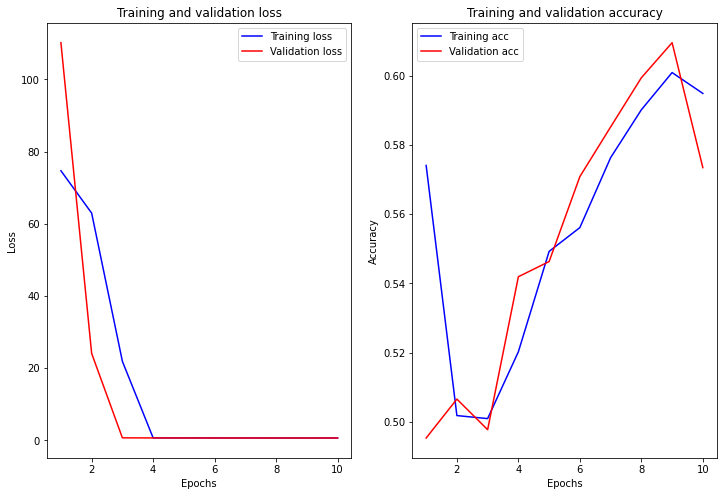

1537/1537 [==============================] - 12s 7ms/step - loss: 0.6735 - accuracy: 0.5783
test_loss    :0.6735298037528992
test_accuracy:0.5783103108406067


In [119]:
trainer.visualization()
trainer.test(lstm_vec_model)

In [120]:
word2vec_model.wv.most_similar("초딩")

[('라이미', 0.6745730638504028),
 ('우비', 0.643349826335907),
 ('멍멍이', 0.6264664530754089),
 ('개새끼', 0.622283935546875),
 ('개구장이', 0.6204812526702881),
 ('무뢰한', 0.6188151240348816),
 ('오리라', 0.6109402179718018),
 ('느림보', 0.607978105545044),
 ('고딩', 0.607582151889801),
 ('물꽃', 0.6050381064414978)]

In [121]:
word2vec_model["초딩"]

/tmp/ipykernel_468/4769972.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  word2vec_model["초딩"]


array([ 1.36360541e-01, -1.70279220e-01, -9.76863727e-02,  1.44492202e-02,
        3.53839830e-03,  1.12721108e-01,  3.12202517e-02, -1.98415533e-01,
       -1.47060473e-02,  4.84370217e-02,  1.13596693e-01,  1.20863482e-01,
        5.17006032e-02,  9.11814794e-02,  7.61676729e-02, -1.59840420e-01,
        4.72553819e-02,  9.51503143e-02,  2.55092774e-02, -1.41835049e-01,
       -2.67878287e-02, -1.27293468e-01, -9.28900391e-02, -9.58871990e-02,
        5.39832599e-02,  6.87926710e-02,  1.88448101e-01, -7.74468407e-02,
       -6.01467602e-02,  1.39780730e-01, -2.31090426e-01,  7.66403824e-02,
        6.51480956e-03,  1.52313247e-01, -7.27886241e-03,  1.61768809e-01,
       -2.09399455e-04,  3.28234695e-02, -6.53301254e-02,  7.85610899e-02,
        3.70433666e-02, -1.82055354e-01, -1.69568792e-01, -1.21481031e-01,
       -9.86518934e-02,  2.81274647e-01, -7.69186765e-04, -1.21569559e-02,
       -1.83578998e-01, -2.37530265e-02, -1.03740826e-01, -8.44165031e-03,
        1.17495554e-02,  

In [122]:
vocab_size = num_words

embedding_matrix=np.zeros((vocab_size, 200))
print(np.shape(embedding_matrix))

(10000, 200)


In [123]:
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [124]:
get_vector(vocab[5])

/tmp/ipykernel_468/3612596859.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in word2vec_model:
/tmp/ipykernel_468/3612596859.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return word2vec_model[word]


array([-1.8007389 , -1.1790098 , -2.4066596 ,  2.1384156 , -0.3537603 ,
        1.3749527 , -4.894612  , -3.6517198 ,  0.4411444 ,  0.78153926,
       -2.696888  , -1.7812852 , -2.1514654 , -4.813236  ,  2.7465918 ,
       -2.1620324 , -0.11467794, -1.2431171 ,  2.3979309 , -1.1060628 ,
       -0.41043055,  1.9500391 ,  0.7821002 ,  1.5899978 ,  1.6447444 ,
       -2.1265035 , -1.7981595 ,  1.7535795 ,  0.53717697, -1.212121  ,
       -4.466316  ,  4.5488324 ,  1.334441  , -0.9070271 ,  1.1931889 ,
        4.1563215 ,  1.9758307 , -0.9437562 , -0.2592725 ,  0.34935686,
        1.8562875 , -3.3249645 ,  1.1221625 ,  1.2836524 ,  3.9211376 ,
        3.8023994 ,  2.766269  ,  0.67293745,  2.2853644 , -5.1131716 ,
        0.32525915, -3.3079958 ,  5.3043513 , -3.8813758 , -0.32960036,
       -1.9527504 ,  3.8865075 , -3.5470378 , -0.21991685,  0.82119733,
       -0.9492492 ,  3.5472107 ,  1.322048  , -0.70640826,  0.52253807,
        1.4683235 , -1.1018689 ,  2.262941  , -0.7204685 , -1.76

In [125]:
korean = data_loader.get_word_to_index()
korean

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시

In [126]:
for i, word in enumerate(vocab):
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

/tmp/ipykernel_468/3612596859.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in word2vec_model:
/tmp/ipykernel_468/3612596859.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return word2vec_model[word]


ValueError: could not broadcast input array from shape (100,) into shape (200,)

### 길이 200으로 똑같이 맞춰주고, 패딩하기

In [127]:
embedding_matrix = np.zeros((len(vocab), 200))

for i, word in enumerate(vocab):
    temp = get_vector(word)
    if temp is not None:
        padded = np.zeros(200)
        padded[:100] = temp  # pad rest with zeros
        embedding_matrix[i] = padded

/tmp/ipykernel_468/3612596859.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if word in word2vec_model:
/tmp/ipykernel_468/3612596859.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return word2vec_model[word]


In [128]:
embedding_matrix[5]

array([-1.80073893, -1.1790098 , -2.4066596 ,  2.13841558, -0.3537603 ,
        1.37495267, -4.89461184, -3.65171981,  0.44114441,  0.78153926,
       -2.69688797, -1.78128517, -2.15146542, -4.81323624,  2.74659181,
       -2.16203237, -0.11467794, -1.24311709,  2.39793086, -1.10606277,
       -0.41043055,  1.95003915,  0.7821002 ,  1.58999777,  1.6447444 ,
       -2.12650347, -1.79815948,  1.7535795 ,  0.53717697, -1.21212101,
       -4.46631622,  4.54883242,  1.33444095, -0.90702713,  1.19318891,
        4.15632153,  1.97583067, -0.94375622, -0.25927249,  0.34935686,
        1.85628748, -3.32496452,  1.12216246,  1.28365242,  3.92113757,
        3.8023994 ,  2.76626897,  0.67293745,  2.28536439, -5.11317158,
        0.32525915, -3.3079958 ,  5.30435133, -3.88137579, -0.32960036,
       -1.95275044,  3.88650751, -3.54703784, -0.21991685,  0.82119733,
       -0.94924921,  3.54721069,  1.32204795, -0.70640826,  0.52253807,
        1.46832347, -1.10186887,  2.26294088, -0.72046852, -1.76

In [129]:
vocab_size = 10000
word_vector_dim = 200

lstm_vec_model = keras.Sequential()
lstm_vec_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=41, trainable=False))
lstm_vec_model.add(keras.layers.LSTM(128, activation = 'relu'))
lstm_vec_model.add(keras.layers.Dense(256, activation='relu'))
lstm_vec_model.add(keras.layers.Dense(128, activation='relu'))
lstm_vec_model.add(keras.layers.Dense(1, activation='sigmoid'))

lstm_vec_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_26 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 129       
Total params: 2,234,497
Trainable params: 234,497
Non-trainable params: 2,000,000
_________________________________________________________________


In [130]:
trainer.train(model=lstm_vec_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
254/254 - 18s - loss: 0.5575 - accuracy: 0.7022 - val_loss: 0.4439 - val_accuracy: 0.7932
Epoch 2/10
254/254 - 16s - loss: 0.4142 - accuracy: 0.8096 - val_loss: 0.3908 - val_accuracy: 0.8218
Epoch 3/10
254/254 - 16s - loss: 0.3725 - accuracy: 0.8320 - val_loss: 0.3747 - val_accuracy: 0.8269
Epoch 4/10
254/254 - 17s - loss: 0.3490 - accuracy: 0.8450 - val_loss: 0.3848 - val_accuracy: 0.8308
Epoch 5/10
254/254 - 17s - loss: 0.3268 - accuracy: 0.8562 - val_loss: 0.3589 - val_accuracy: 0.8348
Epoch 6/10
254/254 - 16s - loss: 0.3118 - accuracy: 0.8650 - val_loss: 0.3510 - val_accuracy: 0.8411
Epoch 7/10
254/254 - 17s - loss: 0.3048 - accuracy: 0.8717 - val_loss: 0.3595 - val_accuracy: 0.8403
Epoch 8/10
254/254 - 16s - loss: 0.2858 - accuracy: 0.8768 - val_loss: 0.3622 - val_accuracy: 0.8390
Epoch 9/10
254/254 - 16s - loss: 0.2691 - accuracy: 0.8856 - val_loss: 0.3629 - val_accuracy: 0.8414
Epoch 10/10
254/254 - 16s - loss: 0.2564 - accuracy: 0.8923 - val_loss: 0.3943 - val_accura

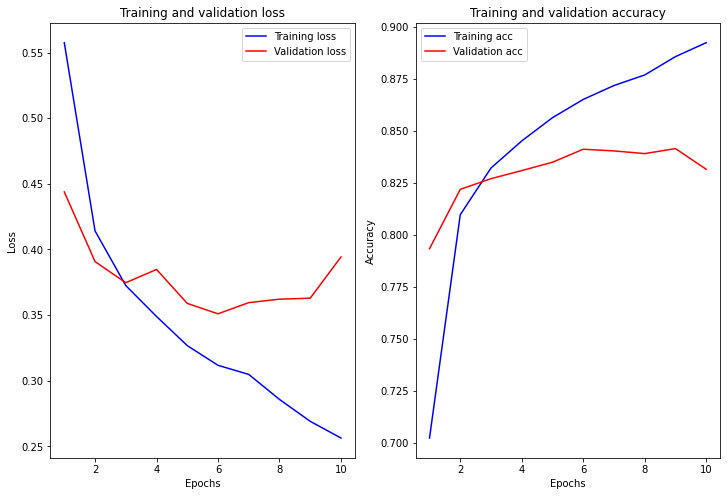

1537/1537 [==============================] - 11s 7ms/step - loss: 0.4044 - accuracy: 0.8355
test_loss    :0.40442517399787903
test_accuracy:0.8355066180229187


In [131]:
trainer.visualization()
trainer.test(lstm_vec_model)

### LSTM 적용전 Attenion 결과 

In [148]:
#Attention Before LSTM
vocab_size = 10000   
word_vector_dim = 200
time_steps = 41

# input layer
inputs = keras.layers.Input(shape=(time_steps,))

embed = keras.layers.Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=41, trainable=False)(inputs)

# attention layer
# inputs.shape = (batch_size, time_steps, input_dim)
a = keras.layers.Permute((2, 1))(embed) 
a = keras.layers.Dense(time_steps, activation='softmax')(a)
a_probs = keras.layers.Permute((2, 1), name='attention_vec')(a)
output_attention_mul  = keras.layers.multiply([embed, a_probs])


# lstm layer
lstm_out = keras.layers.LSTM(256, return_sequences=True, activation='relu')(output_attention_mul)

# fc layer
fc = keras.layers.Dense(64)(lstm_out)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

Att_before_LSTM_vec_model = keras.Model(inputs=[inputs], outputs=output)

Att_before_LSTM_vec_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 41, 200)      2000000     input_8[0][0]                    
__________________________________________________________________________________________________
permute_8 (Permute)             (None, 200, 41)      0           embedding_14[0][0]               
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 200, 41)      1722        permute_8[0][0]                  
___________________________________________________________________________________________

In [149]:
trainer.train(model=Att_before_LSTM_vec_model, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
254/254 - 20s - loss: 0.6305 - accuracy: 0.6392 - val_loss: 0.5821 - val_accuracy: 0.6906
Epoch 2/10
254/254 - 18s - loss: 0.5495 - accuracy: 0.7185 - val_loss: 0.5407 - val_accuracy: 0.7234
Epoch 3/10
254/254 - 18s - loss: 0.5043 - accuracy: 0.7484 - val_loss: 0.4936 - val_accuracy: 0.7562
Epoch 4/10
254/254 - 18s - loss: 0.4719 - accuracy: 0.7694 - val_loss: 0.4699 - val_accuracy: 0.7708
Epoch 5/10
254/254 - 18s - loss: 0.4478 - accuracy: 0.7840 - val_loss: 0.4624 - val_accuracy: 0.7764
Epoch 6/10
254/254 - 18s - loss: 0.4308 - accuracy: 0.7948 - val_loss: 0.4587 - val_accuracy: 0.7752
Epoch 7/10
254/254 - 18s - loss: 0.4163 - accuracy: 0.8029 - val_loss: 0.4442 - val_accuracy: 0.7883
Epoch 8/10
254/254 - 18s - loss: 0.4041 - accuracy: 0.8101 - val_loss: 0.4398 - val_accuracy: 0.7905
Epoch 9/10
254/254 - 18s - loss: 0.3948 - accuracy: 0.8149 - val_loss: 0.4356 - val_accuracy: 0.7935
Epoch 10/10
254/254 - 18s - loss: 0.3854 - accuracy: 0.8204 - val_loss: 0.4367 - val_accura

1537/1537 [==============================] - 12s 8ms/step - loss: 0.4375 - accuracy: 0.7928
test_loss    :0.4374968707561493
test_accuracy:0.7928309440612793


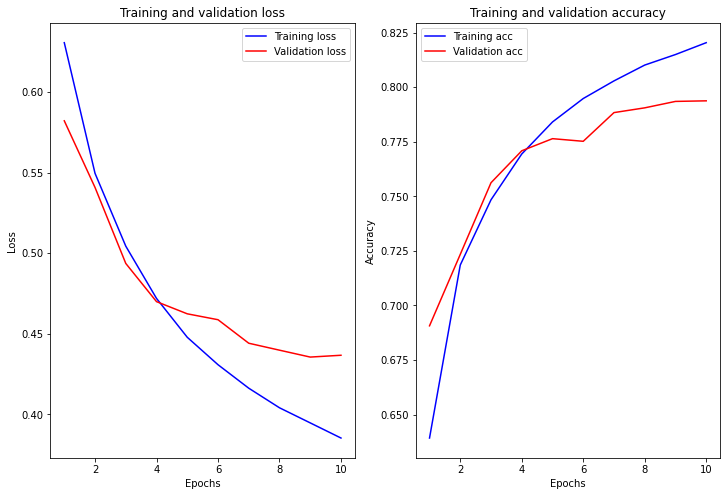

In [151]:
trainer.test(Att_before_LSTM_vec_model)
trainer.visualization()

(200, 41)


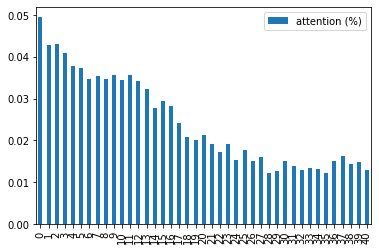

In [134]:
view_attention_vector(Att_before_LSTM_vec_model, x_test, 3)

### LSTM 적용 후 Attention 결과

In [135]:
#Attention After LSTM
vocab_size = 10000   
word_vector_dim = 200
time_steps = 41

# input layer
inputs = keras.layers.Input(shape=(time_steps,))

embed = keras.layers.Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=41, trainable=False)(inputs)

# lstm layer
lstm_out = keras.layers.LSTM(256, return_sequences=True, activation='relu')(embed)

# attention layer
a = keras.layers.Permute((2, 1))(lstm_out)
a = keras.layers.Dense(time_steps, activation='softmax')(a)
a_probs = keras.layers.Permute((2, 1), name='attention_vec')(a)
attention_mul = keras.layers.multiply([lstm_out, a_probs])

# fc layer
fc = keras.layers.Dense(64)(attention_mul)
output = keras.layers.Dense(1, activation='sigmoid')(fc)

Att_after_LSTM_vec = keras.Model(inputs=[inputs], outputs=output)

Att_after_LSTM_vec.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 41, 200)      2000000     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 41, 256)      467968      embedding_10[0][0]               
__________________________________________________________________________________________________
permute_6 (Permute)             (None, 256, 41)      0           lstm_7[0][0]                     
____________________________________________________________________________________________

In [136]:
trainer.train(model=Att_after_LSTM_vec, optimizer='adam', loss='binary_crossentropy', epochs=10, verbose=2)

Epoch 1/10
254/254 - 18s - loss: 0.7188 - accuracy: 0.5455 - val_loss: 0.6926 - val_accuracy: 0.5500
Epoch 2/10
254/254 - 17s - loss: 0.7252 - accuracy: 0.5698 - val_loss: 0.8414 - val_accuracy: 0.5664
Epoch 3/10
254/254 - 17s - loss: 0.7627 - accuracy: 0.5912 - val_loss: 0.6538 - val_accuracy: 0.6100
Epoch 4/10
254/254 - 17s - loss: 0.6396 - accuracy: 0.6357 - val_loss: 0.6258 - val_accuracy: 0.6488
Epoch 5/10
254/254 - 17s - loss: 0.6131 - accuracy: 0.6683 - val_loss: 0.5951 - val_accuracy: 0.6813
Epoch 6/10
254/254 - 17s - loss: 0.5822 - accuracy: 0.6940 - val_loss: 0.5621 - val_accuracy: 0.7079
Epoch 7/10
254/254 - 17s - loss: 0.5611 - accuracy: 0.7099 - val_loss: 0.5504 - val_accuracy: 0.7144
Epoch 8/10
254/254 - 17s - loss: 0.5555 - accuracy: 0.7176 - val_loss: 0.5382 - val_accuracy: 0.7260
Epoch 9/10
254/254 - 17s - loss: 0.5355 - accuracy: 0.7289 - val_loss: 0.5275 - val_accuracy: 0.7339
Epoch 10/10
254/254 - 17s - loss: 0.5242 - accuracy: 0.7383 - val_loss: 0.5179 - val_accura

1537/1537 [==============================] - 13s 8ms/step - loss: 0.5204 - accuracy: 0.7405
test_loss    :0.520405113697052
test_accuracy:0.7404656410217285


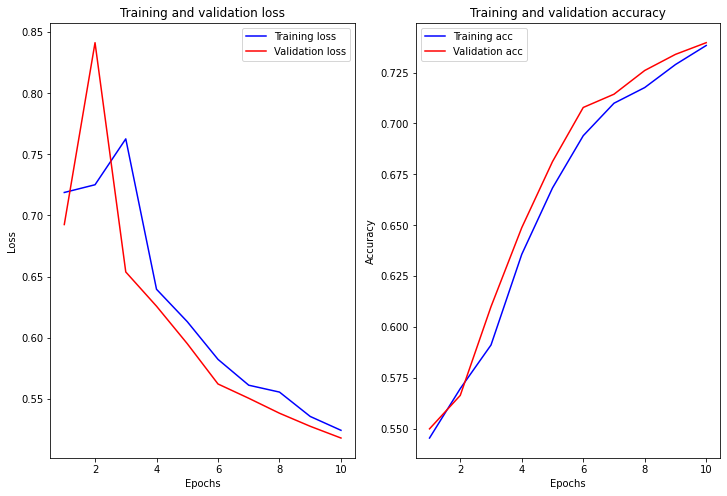

In [137]:
trainer.test(Att_after_LSTM_vec)
trainer.visualization()

In [138]:
x_test[3]

array([ 96,   8,  15,  44, 231, 137, 357, 129,   4,  11, 153,  54,   7,
        10,  42,   4,  70,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

(256, 41)


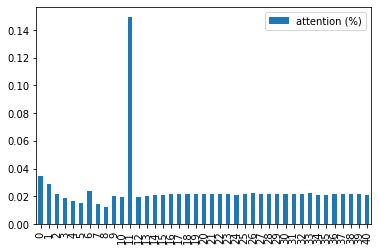

In [139]:
view_attention_vector(Att_after_LSTM_vec, x_test, 3)

In [141]:
pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18913 sha256=169ca10f5ed1dbe096387cba1edae4c38a88bb1a6004106f0a08112ed7905d0a
  Stored in directory: /aiffel/.cache/pip/wheels/78/c1/84/b83a2fd6f1d63e136cba74bac4126bee3b8705eef6486635fd
Successfully built keras-self-attention
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from keras_self_attention import SeqSelfAttention

SelfAttention_vec = keras.Sequential()
SelfAttention_vec.add(keras.layers.Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=41, trainable=False))
#SelfAttention.add(keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True, activation='relu')))
SelfAttention_vec.add(keras.layers.LSTM(256, return_sequences=True, activation='relu'))
SelfAttention_vec.add(SeqSelfAttention(attention_activation='sigmoid'))
SelfAttention_vec.add(keras.layers.Dense(1, activation='sigmoid'))

SelfAttention_vec.summary()

In [153]:
trainer.train(model=SelfAttention_vec, optimizer='adam', loss='binary_crossentropy', epochs=13, verbose=2)

Epoch 1/13
254/254 - 19s - loss: 7.6896 - accuracy: 0.5015 - val_loss: 7.6572 - val_accuracy: 0.5036
Epoch 2/13
254/254 - 17s - loss: 7.6896 - accuracy: 0.5015 - val_loss: 7.6572 - val_accuracy: 0.5036
Epoch 3/13
254/254 - 17s - loss: 7.6896 - accuracy: 0.5015 - val_loss: 7.6572 - val_accuracy: 0.5036
Epoch 4/13
254/254 - 17s - loss: 7.6896 - accuracy: 0.5015 - val_loss: 7.6572 - val_accuracy: 0.5036
Epoch 5/13
254/254 - 17s - loss: 7.6896 - accuracy: 0.5015 - val_loss: 7.6572 - val_accuracy: 0.5036
Epoch 6/13
254/254 - 17s - loss: 7.6896 - accuracy: 0.5015 - val_loss: 7.6572 - val_accuracy: 0.5036
Epoch 7/13
254/254 - 17s - loss: 7.6896 - accuracy: 0.5015 - val_loss: 7.6572 - val_accuracy: 0.5036
Epoch 8/13
254/254 - 17s - loss: 7.6896 - accuracy: 0.5015 - val_loss: 7.6572 - val_accuracy: 0.5036
Epoch 9/13
254/254 - 17s - loss: 7.6896 - accuracy: 0.5015 - val_loss: 7.6572 - val_accuracy: 0.5036
Epoch 10/13
254/254 - 17s - loss: 7.6896 - accuracy: 0.5015 - val_loss: 7.6572 - val_accura

KeyboardInterrupt: 

### 학습이 안되고 계속 고정적으로 되는 이유는 길이가 안맞아서, 이를 해결 하기 위해 길이를 밑에서 맞춰줌

In [ ]:
trainer.test(SelfAttention_vec)
trainer.visualization()

In [154]:
print(embedding_matrix.shape)  # (vocab_size, 200)
print(temp.shape)              # (200,)  <- get_vector로 가져온 벡터

(10000, 200)
(100,)


### 길이 확인후 다른 200, 100 의 길이를 100 으로 맞춰줌

In [164]:
embedding_layer = keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=100,  # 여기!
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
)

In [165]:
from keras_self_attention import SeqSelfAttention

SelfAttention_vec = keras.Sequential()
SelfAttention_vec.add(keras.layers.Embedding(vocab_size, word_vector_dim, weights=[embedding_matrix], input_length=41, trainable=False))
#SelfAttention.add(keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True, activation='relu')))
SelfAttention_vec.add(keras.layers.LSTM(256, return_sequences=True, activation='relu'))
SelfAttention_vec.add(SeqSelfAttention(attention_activation='sigmoid'))
SelfAttention_vec.add(keras.layers.Dense(1, activation='sigmoid'))

SelfAttention_vec.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 41, 256)           467968    
_________________________________________________________________
seq_self_attention_3 (SeqSel (None, None, 256)         16449     
_________________________________________________________________
dense_41 (Dense)             (None, None, 1)           257       
Total params: 2,484,674
Trainable params: 484,674
Non-trainable params: 2,000,000
_________________________________________________________________


In [166]:
trainer.train(model=SelfAttention_vec, optimizer='adam', loss='binary_crossentropy', epochs=5, verbose=2)

Epoch 1/5
254/254 - 20s - loss: 0.5031 - accuracy: 0.7485 - val_loss: 0.4364 - val_accuracy: 0.7930
Epoch 2/5
254/254 - 18s - loss: 0.3900 - accuracy: 0.8231 - val_loss: 0.3845 - val_accuracy: 0.8258
Epoch 3/5
254/254 - 17s - loss: 0.3488 - accuracy: 0.8448 - val_loss: 0.3607 - val_accuracy: 0.8386
Epoch 4/5
254/254 - 17s - loss: 0.3207 - accuracy: 0.8595 - val_loss: 0.3490 - val_accuracy: 0.8457
Epoch 5/5
254/254 - 18s - loss: 0.2922 - accuracy: 0.8733 - val_loss: 0.3564 - val_accuracy: 0.8454


1537/1537 [==============================] - 12s 8ms/step - loss: 0.3604 - accuracy: 0.8448
test_loss    :0.36040136218070984
test_accuracy:0.844835638999939


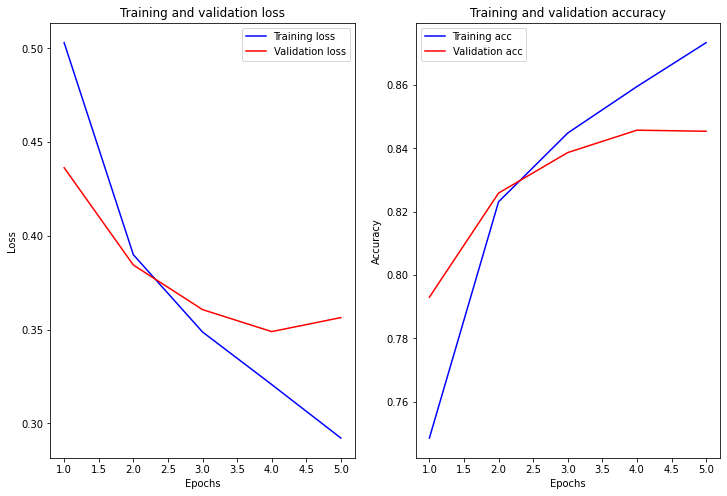

In [167]:
trainer.test(SelfAttention_vec)
trainer.visualization()